<a href="https://colab.research.google.com/github/Whomstt/CS4287Assign3/blob/master/steven2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Authors
Cathal Crowe - 21320128 \
Robert Flanagan - 21311625 \
Steven Lavelle - 21316945

### Execution
The code executes to the end without an error.

### References
https://keras.io/examples/rl/deep_q_network_breakout \
https://ale.farama.org/environments/breakout \
https://gymnasium.farama.org \
https://github.com/KJ-Waller/DQN-PyTorch-Breakout/blob/master/Breakout/DQN_model.py

In [8]:
# !pip install gymnasium
# !pip install ale_py

In [9]:
# Import our dependencies
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
from gymnasium.wrappers import (
    AtariPreprocessing,
    FrameStackObservation,
    RecordVideo,
)
import ale_py
import matplotlib.pyplot as plt

In [10]:
# Configure our parameters
seed = 42
gamma = 0.99
learning_rate = 0.0003
epsilon_start = 1
epsilon_end = 0.1
epsilon_decay = 0.999
min_epsilon = 0.3
batch_size = 64
max_steps_per_episode = 1000
max_episodes = 400
replay_buffer_size = 100000
target_update_frequency = 500
start_training_after = 10000
update_after_actions = 4
video_folder = "recorded_episodes"
epsilon = epsilon_start


In [11]:
# Environment setup
os.makedirs(video_folder, exist_ok=True)

gym.register_envs(ale_py)
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=lambda x: x % 100 == 0,
)
env = AtariPreprocessing(env, frame_skip=1)
env = FrameStackObservation(env, 4)

env.reset(seed=seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/recorded_episodes folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Using device: cuda


In [12]:
# Define our model
num_actions = 4
input_dim = (4, 84, 84)
output_dim = num_actions
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.input_dim = input_dim
        channels, _, _ = input_dim

        # Three convolutional layers
        self.l1 = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Fully connected layers
        conv_output_size = self.conv_output_dim()
        lin1_output_size = 512

        # Two linear layers
        self.l2 = nn.Sequential(
            nn.Linear(conv_output_size, lin1_output_size),
            nn.ReLU(),
            nn.Linear(lin1_output_size, output_dim),
        )

    # Returns the output dimension of the convolutional layers
    def conv_output_dim(self):
        x = torch.zeros(1, *self.input_dim)
        x = self.l1(x)
        return int(np.prod(x.shape))

    # Forward pass
    def forward(self, x):
        x = self.l1(x)
        x = x.view(x.shape[0], -1)
        actions = self.l2(x)

        return actions

model = DQN(input_dim, output_dim).to(device)
model_target = DQN(input_dim, output_dim).to(device)
model_target.load_state_dict(model.state_dict())

optimizer = optim.Adam(model.parameters(), learning_rate)

In [13]:
# Experience replay buffers
action_history, state_history, state_next_history = [], [], []
rewards_history, done_history = [], []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

Episode 1 finished with reward 1.0
Episode 2 finished with reward 0.0
running reward: 0.50 at episode 2, frame count 500
Episode 3 finished with reward 1.0
Episode 4 finished with reward 0.0
Episode 5 finished with reward 2.0
running reward: 0.80 at episode 5, frame count 1000
Episode 6 finished with reward 4.0
Episode 7 finished with reward 0.0
Episode 8 finished with reward 0.0
running reward: 1.00 at episode 8, frame count 1500
Episode 9 finished with reward 0.0
Episode 10 finished with reward 1.0
Episode 11 finished with reward 1.0
running reward: 0.91 at episode 11, frame count 2000
Episode 12 finished with reward 1.0
Episode 13 finished with reward 4.0
running reward: 1.15 at episode 13, frame count 2500
Episode 14 finished with reward 1.0
Episode 15 finished with reward 3.0
Episode 16 finished with reward 0.0
running reward: 1.19 at episode 16, frame count 3000
Episode 17 finished with reward 1.0
Episode 18 finished with reward 1.0
running reward: 1.17 at episode 18, frame count

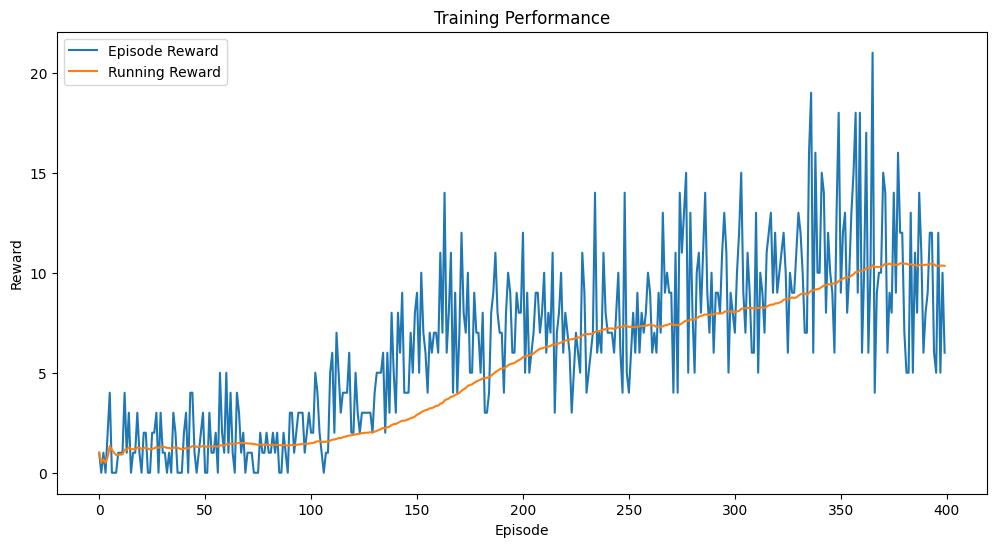

In [14]:
# Plot training performance
def plot_training_performance(episode_rewards, running_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, label='Episode Reward')
    plt.plot(running_rewards, label='Running Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Performance')
    plt.legend()
    plt.show()

# Collect episode rewards and running rewards
episode_rewards = []
running_rewards = []

# Train the model
try:
    while True:
        observation, _ = env.reset()
        state = np.array(observation)
        episode_reward = 0

        for timestep in range(1, max_steps_per_episode):
            frame_count += 1

            # Epsilon-greedy exploration
            if frame_count < start_training_after or epsilon > np.random.rand(1)[0]:
                action = np.random.choice(num_actions)
            else:
                with torch.no_grad():
                    state_tensor = (
                        torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    )
                    action_probs = model(state_tensor)
                    action = action_probs.argmax().cpu().item()

            # Decay exploration
            epsilon = max(epsilon_end, epsilon - epsilon_decay)

            # Environment step
            state_next, reward, done, _, _ = env.step(action)
            state_next = np.array(state_next)

            reward = max(min(reward, 1), -1)

            episode_reward += reward

            # Save experiences
            action_history.append(action)
            state_history.append(state)
            state_next_history.append(state_next)
            done_history.append(done)
            rewards_history.append(reward)
            state = state_next

            # Update network
            if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
                # Sample batch
                indices = np.random.choice(range(len(done_history)), size=batch_size)

                # Prepare batch tensors
                state_sample = torch.tensor(
                    np.array([state_history[i] for i in indices]), dtype=torch.float32
                ).to(device)
                state_next_sample = torch.tensor(
                    np.array([state_next_history[i] for i in indices]), dtype=torch.float32
                ).to(device)
                rewards_sample = torch.tensor(
                    [rewards_history[i] for i in indices], dtype=torch.float32
                ).to(device)
                action_sample = torch.tensor(
                    [action_history[i] for i in indices], dtype=torch.long
                ).to(device)
                done_sample = torch.tensor(
                    [float(done_history[i]) for i in indices], dtype=torch.float32
                ).to(device)

                # Predict future rewards
                with torch.no_grad():
                    future_rewards = model_target(state_next_sample)
                    updated_q_values = rewards_sample + gamma * future_rewards.max(1)[0] * (
                        1 - done_sample
                    )

                # Compute Q-values
                q_values = model(state_sample)
                q_action = q_values.gather(1, action_sample.unsqueeze(1)).squeeze(1)

                # Compute loss
                loss = F.smooth_l1_loss(q_action, updated_q_values)

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Update target network
            if frame_count % target_update_frequency == 0:
                model_target.load_state_dict(model.state_dict())
                print(
                    f"running reward: {running_reward:.2f} at episode {episode_count}, frame count {frame_count}"
                )

            # Trim memory
            if len(rewards_history) > replay_buffer_size:
                for history in [
                    rewards_history,
                    state_history,
                    state_next_history,
                    action_history,
                    done_history,
                ]:
                    del history[:1]

            if done:
                break

        # Update running reward
        episode_reward_history.append(episode_reward)
        if len(episode_reward_history) > 100:
            del episode_reward_history[:1]
        running_reward = np.mean(episode_reward_history)

        episode_count += 1

        if episode_count > 100:
            target_update_frequency = 1000
            min_epsilon = 0.1



        print(f"Episode {episode_count} finished with reward {episode_reward}")

        # Collect rewards for plotting
        episode_rewards.append(episode_reward)
        running_rewards.append(running_reward)

        # Termination conditions
        if running_reward > 40:
            print(f"Solved at episode {episode_count}!")
            break

        if max_episodes > 0 and episode_count >= max_episodes:
            print(f"Stopped at episode {episode_count}!")
            break
finally:
    env.close()

# Plot the training performance
plot_training_performance(episode_rewards, running_rewards)